In [0]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Problem Definition

In [0]:
class Problem:
  
  nVar = 4 # Number of Unknown Variables
  varMin = -1.0 # Lower bound of decision variables
  varMax = 1.0 # Upper bond
  
  
  ### params and function for solving path planning ###
  def __init__(self):
    varMin = self.varMin
    varMax = self.varMax
    nVar = self.nVar
    
    self.startPos = [np.random.uniform(varMin,varMax),np.random.uniform(varMin,varMax)]
    # startPos = [-0.25,-0.75]
    # startPos = [-1.0,-1.0]
    self.goalPos = [0.0,0.75] 
    self.nPos = nVar/2
    self.wallList = np.array([[[ 0.5 , 0.0],[ 1.0 ,  0.0]], # wall1
                         [[   0.0, 0.0],[-0.75,  0.0]], # wall2
                         [[-0.75, 0.0],[-0.75, -0.5]]]) # wall3
  
  def costFunction(self,x):
    startPos = self.startPos
    goalPos = self.goalPos 
    nPos = self.nPos # Number of Position
    
    
    ## Caluculate the Length of Path
    length = 0
    # Distance Between Start and First Node
    p1 = startPos
    p2 = [x[0],x[1]]
    wallCrossing = self.crossWall(p1,p2,self.wallList)
    if wallCrossing:
      length += float('inf') # If cross wall
    else:
      length += np.sqrt((startPos[0]-x[0])**2 + (startPos[1]-x[1])**2) 
    
    # Distance Between Goal and Last Node
    p1 = [x[-2],x[-1]]
    p2 = goalPos
    wallCrossing = self.crossWall(p1,p2,self.wallList)
    if wallCrossing:
      length += float('inf') # If cross wall
    else:
      length += np.sqrt((goalPos[0]-x[-2])**2 + (goalPos[1]-x[-1])**2) 
    
    # Distance Between Each Nodes
    for i in range(nPos-1):
      p1 = [x[2*i],x[2*i+1]]
      p2 = [x[2*i+2],x[2*i+3]]
      wallCrossing = self.crossWall(p1,p2,self.wallList)
      
      if wallCrossing:
        length += float('inf') # If cross wall
      else:
        length += np.sqrt((x[2*i+2]-x[2*i])**2 + (x[2*i+3]-x[2*i+1])**2) 

    return length
  
  def crossWall(self,p1,p2,wallList):
    crossWallNum = 0
    for wall in wallList:
      p3 = wall[0]
      p4 = wall[1]
      t1 = (p1[0] - p2[0]) * (p3[1] - p1[1]) + (p1[1] - p2[1]) * (p1[0] - p3[0])
      t2 = (p1[0] - p2[0]) * (p4[1] - p1[1]) + (p1[1] - p2[1]) * (p1[0] - p4[0])
      t3 = (p3[0] - p4[0]) * (p1[1] - p3[1]) + (p3[1] - p4[1]) * (p3[0] - p1[0])
      t4 = (p3[0] - p4[0]) * (p2[1] - p3[1]) + (p3[1] - p4[1]) * (p3[0] - p2[0])
      if t1*t2<=0.04 and t3*t4<=0.04:
        crossWallNum += 1
    if crossWallNum ==0:
      wallCrossing = False
    else:
      wallCrossing = True
    
    return wallCrossing

# Visualization of Problem

In [0]:
problem = Problem()
wallList = problem.wallList
startPos = problem.startPos
goalPos = problem.goalPos

(-1, 1)

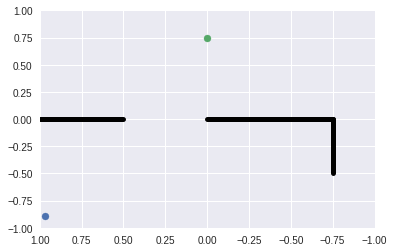

In [20]:
for wall in wallList:
  plt.plot([wall[0][0],wall[1][0]], [wall[0][1],wall[1][1]], 'k-', lw=5)

plt.scatter(startPos[0],startPos[1]) # Plot Start Position
plt.scatter(goalPos[0],goalPos[1]) # Plot Goal Position

plt.xlim(1,-1)
plt.ylim(-1,1)

# Parameters of PSO

In [0]:
class Params:
  maxIt = 100        # Maximum number of iteration
  nPop = 50           # Population size (swarm size)
  w = 1               # Intertia coefficient
  wDamp = 0.995         # Damping Ratio of Intertia Coefficient
  c1 = 2              # Personal accelation coefficient
  c2 = 2              # Social accelation coefficient
  showIterInfo = False

# Initialization

In [0]:
# Class for each particle
class Particle:

  Position = []
  Velocity = []
  Cost = []
  bestPosition = []
  bestCost = []


In [0]:
# Class for Global Best
class GlobalBest:
  
  Cost = float('inf')
  Position = []

In [0]:
# Initialize 
global_best = GlobalBest()
params = Params()
problem = Problem()

# problem
nVar = problem.nVar # Number of Unknown Variables
varMin = problem.varMin # Lower bound of decision variables
varMax = problem.varMax

wallList = problem.wallList
startPos = problem.startPos
goalPos = problem.goalPos

# paramaters
maxIt = params.maxIt        # Maximum number of iteration
nPop = params.nPop           # Population size (swarm size)
w =  params.w             # Intertia coefficient
wDamp =  params.wDamp      # Damping Ratio of Intertia Coefficient
c1 = params.c1           # Personal accelation coefficient
c2 = params.c2           # Social accelation coefficient
showIterInfo = params.showIterInfo

maxVelocity = 0.2*(varMax - varMin)
minVelocity = - maxVelocity


In [0]:
# Create Population Array
particle = np.array([Particle() for i in range(params.nPop)])

# Initialize Population Array
while len(global_best.Position)==0:
  for i in range(params.nPop):
    particle[i].Position = np.array([np.random.uniform(varMin,varMax) for j in range(nVar)])
    particle[i].Velocity = np.zeros(nVar)
    particle[i].Cost = problem.costFunction(particle[i].Position)
    particle[i].bestPosition = particle[i].Position
    particle[i].bestCost = particle[i].Cost

    # Update Global Best
    if particle[i].bestCost < global_best.Cost:
      global_best.Cost = particle[i].bestCost
      global_best.Position = particle[i].bestPosition


In [0]:
# Array to Hold Best Cost Value on Each Iteration
bestCostList = []
bestPositionList =[]

# Main Loop of PSO

In [0]:

for it in range(maxIt):
    for i in range(nVar):
      # Update Velocity
      particle[i].Velocity = w * particle[i].Velocity \
                            + np.random.rand()*c1*(particle[i].bestPosition - particle[i].Position) \
                            + np.random.rand()*c2*(global_best.Position - particle[i].Position)
      # Apply Velocity Limits
      particle[i].Velocity = np.array([max(particle[i].Velocity[k],minVelocity) for k in range(nVar)])
      particle[i].Velocity = np.array([min(particle[i].Velocity[k],maxVelocity) for k in range(nVar)])
      
      
      # Update Position
      particle[i].Position = particle[i].Position + particle[i].Velocity

      # Apply Lower and Upper Bound Limits
      particle[i].Position = np.array([max(particle[i].Position[k],varMin) for k in range(nVar)])
      particle[i].Position = np.array([min(particle[i].Position[k],varMax) for k in range(nVar)])

      # Ebaluation
      particle[i].Cost = problem.costFunction(particle[i].Position)
      # print(particle[i].Cost)
      # Update Personal Best
      if particle[i].Cost < particle[i].bestCost:
        particle[i].bestPosition = particle[i].Position
        particle[i].bestCost = particle[i].Cost
        
        # Update Global Best
        if particle[i].bestCost < global_best.Cost:
          global_best.Cost = particle[i].bestCost
          global_best.Position = particle[i].bestPosition
      
    # Store the Best Cost Value
    bestCostList.append(global_best.Cost)
    bestPositionList.append(global_best.Position)
    
    # Display Iteration Information
    if showIterInfo:
      print("Iteration:" + str(it)+ "--Best Cost =" + str(global_best.Cost))

      
    # Damping Intertia
    w = w*wDamp
    

# Results

In [28]:
global_best.Position

array([0.19662189, 0.81946306, 0.11749094, 0.80089545])

In [0]:
pathX = [startPos[0]]
pathX.extend([global_best.Position[2*i] for i in range(problem.nPos)])
pathX.extend([goalPos[0]])

pathY = [startPos[1]]
pathY.extend([global_best.Position[2*i+1] for i in range(problem.nPos)])
pathY.extend([goalPos[1]])

(-1, 1)

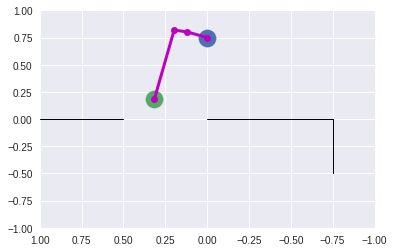

In [30]:
for wall in wallList:
  plt.plot([wall[0][0],wall[1][0]], [wall[0][1],wall[1][1]], 'k-', lw=1)


plt.plot(pathX,pathY,"m-o",lw=3)
plt.scatter(goalPos[0],goalPos[1],s=300,marker='o') # Plot Goal Position
plt.scatter(startPos[0],startPos[1],s=300,marker='o') # Plot Start Position

plt.xlim(1,-1)
plt.ylim(-1,1)

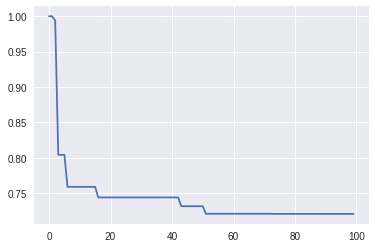

In [16]:
plt.plot(bestCostList)
# plt.xscale('log')
# plt.yscale('log')

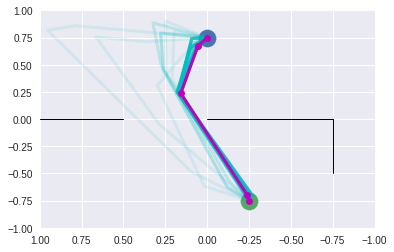

In [830]:
for wall in wallList:
  plt.plot([wall[0][0],wall[1][0]], [wall[0][1],wall[1][1]], 'k-', lw=1)

plt.scatter(goalPos[0],goalPos[1],s=300,marker='o') # Plot Goal Position
plt.scatter(startPos[0],startPos[1],s=300,marker='o') # Plot Start Position

plt.xlim(1,-1)
plt.ylim(-1,1)

for k in range(maxIt):
  pathX = [startPos[0]]
  pathX.extend([bestPositionList[k][2*i] for i in range(problem.nPos)])
  pathX.extend([goalPos[0]])

  pathY = [startPos[1]]
  pathY.extend([bestPositionList[k][2*i+1] for i in range(problem.nPos)])
  pathY.extend([goalPos[1]])
  plt.plot(pathX,pathY,"c-",lw=3,alpha=0.1)

plt.plot(pathX,pathY,"m-o",lw=3)
  
